In [1]:
import re
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier  
import seaborn as sb
from sklearn import tree
import pydotplus
import matplotlib as plt
from IPython.display import Image
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.interactive(False)
%matplotlib inline

C:\Users\yhoresh\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
sentence_1 = "For sale - Apples and Oranges"
sentence_2 = "Apple and Orange fruits for sale"


In [3]:
sentence_1 = sentence_1.lower()
sentence_2 = sentence_2.lower()

In [4]:
sentence_1, sentence_2

('for sale - apples and oranges', 'apple and orange fruits for sale')

In [5]:
sentence_1 = re.sub('\W+', '', sentence_1)
sentence_2 = re.sub('\W+', '', sentence_2)
sentence_1, sentence_2

('forsaleapplesandoranges', 'appleandorangefruitsforsale')

In [6]:
def get_3_tuples(x):
    return set(x[i:i+3] for i in range(len(x)-4))

In [7]:
sentence_1_tuples = get_3_tuples(sentence_1) 
sentence_1_tuples

{'ale',
 'and',
 'ang',
 'app',
 'dor',
 'eap',
 'esa',
 'for',
 'lea',
 'les',
 'ndo',
 'ora',
 'ors',
 'ple',
 'ppl',
 'ran',
 'rsa',
 'sal',
 'san'}

In [8]:
sentence_2_tuples = get_3_tuples(sentence_2) 
sentence_2_tuples

{'and',
 'ang',
 'app',
 'dor',
 'ean',
 'efr',
 'for',
 'fru',
 'gef',
 'its',
 'lea',
 'ndo',
 'nge',
 'ora',
 'ors',
 'ple',
 'ppl',
 'ran',
 'rsa',
 'rui',
 'sfo',
 'tsf',
 'uit'}

In [9]:
sent_intersection = sentence_1_tuples.intersection(sentence_2_tuples)
sent_intersection

{'and',
 'ang',
 'app',
 'dor',
 'for',
 'lea',
 'ndo',
 'ora',
 'ors',
 'ple',
 'ppl',
 'ran',
 'rsa'}

In [10]:
sent_union = sentence_1_tuples.union(sentence_2_tuples)
sent_union

{'ale',
 'and',
 'ang',
 'app',
 'dor',
 'ean',
 'eap',
 'efr',
 'esa',
 'for',
 'fru',
 'gef',
 'its',
 'lea',
 'les',
 'ndo',
 'nge',
 'ora',
 'ors',
 'ple',
 'ppl',
 'ran',
 'rsa',
 'rui',
 'sal',
 'san',
 'sfo',
 'tsf',
 'uit'}

In [11]:
len(sent_intersection) 

13

In [12]:
len(sent_union)

29

In [13]:
len(sent_intersection)  / len(sent_union)

0.4482758620689655

# A simple classifier

In [14]:
# load the titanic dataset
df = pd.read_csv(r'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

In [15]:
df.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
437,438,1,2,"Richards, Mrs. Sidney (Emily Hocking)",female,24.0,2,3,29106,18.7500,NaN,S
259,260,1,2,"Parrish, Mrs. (Lutie Davis)",female,50.0,0,1,230433,26.0000,NaN,S
552,553,0,3,"O'Brien, Mr. Timothy",male,NaN,0,0,330979,7.8292,NaN,Q
564,565,0,3,"Meanwell, Miss. (Marion Ogden)",female,NaN,0,0,SOTON/O.Q. 392087,8.0500,NaN,S
468,469,0,3,"Scanlan, Mr. James",male,NaN,0,0,36209,7.7250,NaN,Q
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C
292,293,0,2,"Levy, Mr. Rene Jacques",male,36.0,0,0,SC/Paris 2163,12.8750,D,C
199,200,0,2,"Yrois, Miss. Henriette (""Mrs Harbeck"")",female,24.0,0,0,248747,13.0000,NaN,S
517,518,0,3,"Ryan, Mr. Patrick",male,NaN,0,0,371110,24.1500,NaN,Q
626,627,0,2,"Kirkland, Rev. Charles Leonard",male,57.0,0,0,219533,12.3500,NaN,Q


<AxesSubplot:>

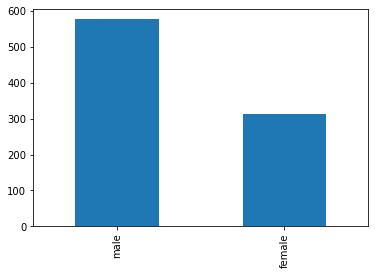

In [16]:
df.Sex.value_counts().plot(kind='bar')

In [17]:
def normalized_redacted_name(name):
    name = name.lower()
    name = re.sub('mr\.|miss\.|mrs\.', '', name)
    name = re.sub('\W+', '', name)
    return name

In [18]:
%%time
df['norm_name'] = df['Name'].apply(normalized_redacted_name)
df['tuples'] = df['norm_name'].apply(get_3_tuples)

CPU times: total: 15.6 ms
Wall time: 7.98 ms


In [19]:
df[['Name', 'norm_name','tuples']]

,Name,norm_name,tuples
0,"Braund, Mr. Owen Harris",braundowenharris,"{ndo, owe, enh, rau, nha, dow, und, aun, bra, ..."
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",cumingsjohnbradleyflorencebriggsthayer,"{hay, nbr, gsj, ohn, joh, ore, lor, dle, enc, ..."
2,"Heikkinen, Miss. Laina",heikkinenlaina,"{lai, nla, enl, eik, nen, ine, hei, kki, ikk, ..."
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",futrellejacquesheathlilymaypeel,"{jac, ell, lym, esh, may, lej, ily, thl, ues, ..."
4,"Allen, Mr. William Henry",allenwilliamhenry,"{lle, enw, iam, amh, all, nwi, len, lli, ill, ..."
...,...,...,...
886,"Montvila, Rev. Juozas",montvilarevjuozas,"{ont, vju, are, mon, rev, juo, evj, uoz, tvi, ..."
887,"Graham, Miss. Margaret Edith",grahammargaretedith,"{rga, edi, amm, are, ted, arg, gar, mma, rah, ..."
888,"Johnston, Miss. Catherine Helen ""Carrie""",johnstoncatherinehelencarrie,"{nca, ohn, ine, joh, enc, ehe, eri, len, car, ..."
889,"Behr, Mr. Karl Howell",behrkarlhowell,"{lho, owe, hrk, how, rka, beh, ehr, rlh, kar, ..."


In [20]:
%%time
list_of_tokens = []
for ind, row in df.iterrows():

    tuples = dict()
    for item in row.tuples:
        tuples[item] = 1
        
    tuples['index'] = ind
    tuples['gender'] = 1 if row.Sex=='female' else 0
    
    list_of_tokens.append(tuples)
    

CPU times: total: 46.9 ms
Wall time: 42.9 ms


In [21]:
list_of_tokens[0:1]

[{'ndo': 1,
  'owe': 1,
  'enh': 1,
  'rau': 1,
  'nha': 1,
  'dow': 1,
  'und': 1,
  'aun': 1,
  'bra': 1,
  'wen': 1,
  'har': 1,
  'arr': 1,
  'index': 0,
  'gender': 0}]

In [22]:
three_tuples_df = pd.DataFrame(list_of_tokens)
three_tuples_df.fillna(0, inplace=True)
three_tuples_df.sample(5)

,ndo,owe,enh,rau,nha,dow,und,aun,bra,wen,...,etn,vju,juo,uoz,ntv,neh,hrk,beh,rlh,ypa
81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
target_label = three_tuples_df.gender
three_tuples_df.drop('gender', axis=1, inplace=True)

In [24]:
target_label.value_counts()

0    577
1    314
Name: gender, dtype: int64

In [25]:
# too many columns with a single value
list_of_columns_with_a_two_or_less_ones = sum(three_tuples_df.values) <= 2

In [26]:
# remove columns with only a single value
three_tuples_df.drop(three_tuples_df.columns[list_of_columns_with_a_two_or_less_ones], axis=1, inplace=True)
three_tuples_df.sample(5)

,owe,enh,rau,nha,dow,und,aun,bra,wen,har,...,lum,olo,ryh,ebl,sol,has,ebe,dth,sno,edo
875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
%%time

X_train, X_test, y_train, y_test = train_test_split(three_tuples_df, target_label, test_size=0.2, random_state=42)

CPU times: total: 15.6 ms
Wall time: 6.96 ms


In [28]:
%%time
classifier = XGBClassifier( use_label_encoder=False) #class_weight='balanced',
model = classifier.fit(X_train, y_train)

prediction = model.predict(X_test)

print(classification_report(y_test, prediction))

confusion_matrix(y_test, prediction)


[02:21:37] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\yhoresh\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


              precision    recall  f1-score   support

           0       0.81      0.90      0.85       110
           1       0.81      0.67      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.81      0.81       179

CPU times: total: 8.31 s
Wall time: 744 ms


array([[99, 11],
       [23, 46]], dtype=int64)

<AxesSubplot:xlabel='imp', ylabel='name'>

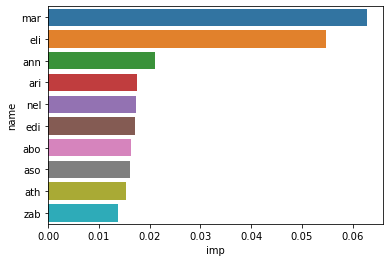

In [29]:
#feature_importances
feature_imp = pd.DataFrame(data=list(zip(model.feature_importances_, X_test.columns)), columns=['imp', 'name'])
feature_imp.sort_values(by='imp', ascending=False, inplace=True)

sb.barplot(x=feature_imp.imp[0:10], y=feature_imp.name[0:10])


# A Decision Tree

DecisionTreeClassifier(max_depth=3, min_samples_leaf=3, min_samples_split=3)

True

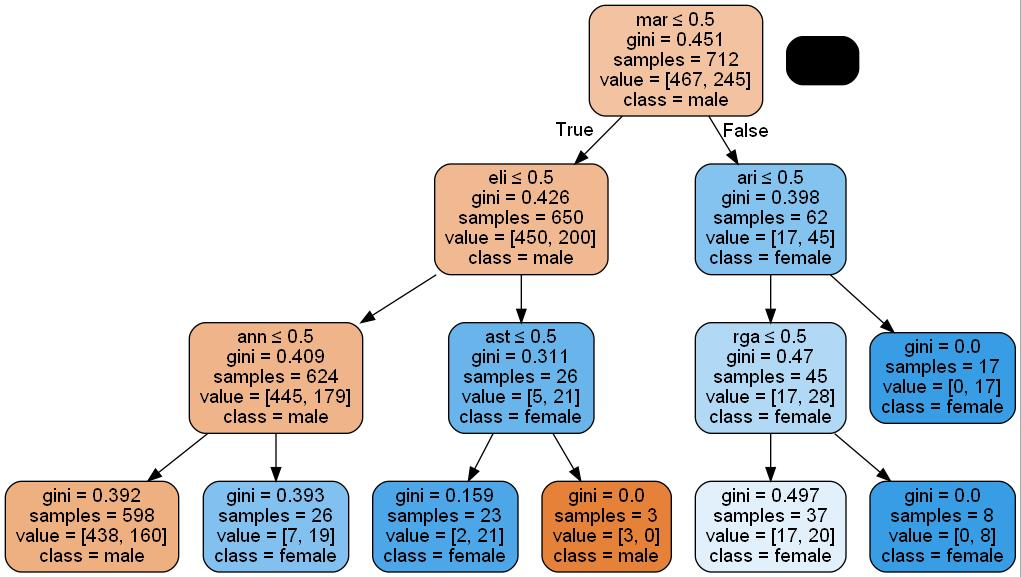

In [30]:
tree_classifier = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=3, min_samples_split=3)
tree_classifier.fit(X_train, y_train)

dot_data = tree.export_graphviz(tree_classifier, out_file=None, class_names=['male','female'], feature_names=X_test.columns, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_jpeg('dummy.jpeg')
Image(filename='dummy.jpeg', width=1000, height=1000)

prediction = tree_classifier.predict(X_test)


In [31]:
print(classification_report(y_test, prediction))

confusion_matrix(y_test, prediction)

              precision    recall  f1-score   support

           0       0.71      0.90      0.80       110
           1       0.72      0.42      0.53        69

    accuracy                           0.72       179
   macro avg       0.72      0.66      0.66       179
weighted avg       0.72      0.72      0.69       179



array([[99, 11],
       [40, 29]], dtype=int64)